In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from LSSVM import lssvmMatrix, prepareLabels
from VQLSSVM import VQLSSVM

np.set_printoptions(precision=4, suppress=True)

In [2]:
shots: int = 10000
gamma: float = 0.01 # regularization parameter
subsetSize: int = 7
classToFilterOut: int = 2

In [3]:
def prepareDataset(normalizeValues: bool = False, dataset: str = "iris") -> (np.ndarray, np.ndarray, np.array, np.array):
    if dataset == "iris":
        X,y = datasets.load_iris(return_X_y=True)
        X = X[y!=classToFilterOut]
        y = y[y!=classToFilterOut]
    elif dataset == "breastCancer":
        X,y = datasets.load_breast_cancer(return_X_y=True)
    elif dataset == "dummyData":
        X, y = datasets.make_classification(
            n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
        )
    else: 
        raise ValueError("Dataset not yet implemented")
    
    y: np.array = np.where(y == 0, -1, 1) # might cause some problems in a future

    if normalizeValues:
        max = np.max(X, axis=0)
        min = np.min(X, axis=0)
        X = (2*X - min - max) / (max - min)
    return train_test_split(X, y, test_size=(X.shape[0]-subsetSize)/(X.shape[0]), random_state=42)

In [4]:
xTrain, xTest, yTrain, yTest = prepareDataset(normalizeValues=True, dataset="breastCancer")

Condition number of the matrix:  4397.40886173452
LS-SVM Matrix:
 [[  0.       1.       1.       1.       1.       1.       1.       1.    ]
 [  1.     106.3387   7.9382   4.45     7.0972   9.6707   7.1253   8.6627]
 [  1.       7.9382 112.9724   9.9     11.3853  14.9474  10.5049  13.5895]
 [  1.       4.45     9.9    112.9916   8.8691  10.9625   7.0351   9.8842]
 [  1.       7.0972  11.3853   8.8691 111.003   12.9767   9.92    12.5543]
 [  1.       9.6707  14.9474  10.9625  12.9767 119.5408  11.9793  17.2147]
 [  1.       7.1253  10.5049   7.0351   9.92    11.9793 109.8428  11.4212]
 [  1.       8.6627  13.5895   9.8842  12.5543  17.2147  11.4212 116.0885]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ',
 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI',
 'ZXX', 'ZXZ', 'ZYY', 'ZZI', 'ZZX', 'ZZZ']
Pauli matrix coeffitients [(98.59722459143913+0j), (8.824469127288015+0j), (-

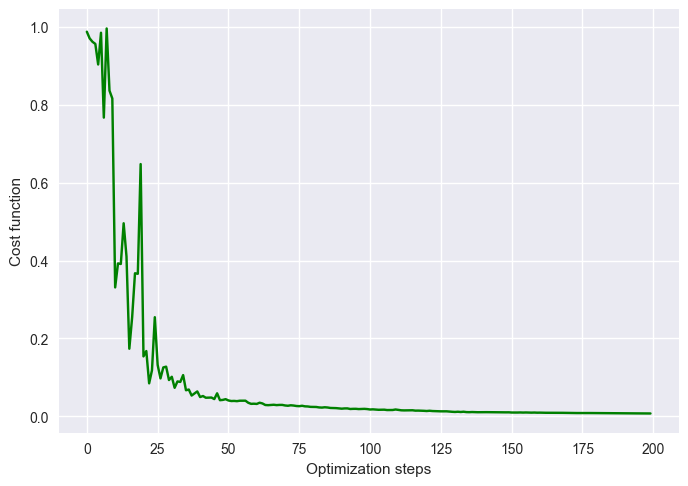

In [5]:
vqlssvmVectors: VQLSSVM = VQLSSVM(gamma, shots)
vqlssvmVectors.train(xTrain, yTrain, quantumSimulation=False, verbose=True, iterations = 200)

vqlssvmVectors.plotCost()

In [6]:
print(vqlssvmVectors.predict(xTest))

[ 0.1324+0.j -0.0307+0.j  0.0305+0.j  0.1901+0.j  0.2193+0.j -0.1534+0.j
 -0.1118+0.j  0.07  +0.j  0.1137+0.j  0.1643+0.j  0.1058+0.j  0.0391+0.j
  0.1214+0.j  0.08  +0.j  0.1648+0.j -0.002 +0.j  0.153 +0.j  0.219 +0.j
  0.2909+0.j -0.0624+0.j  0.1291+0.j  0.1407+0.j -0.114 +0.j  0.2062+0.j
  0.1544+0.j  0.1962+0.j  0.1681+0.j  0.1461+0.j  0.1481+0.j -0.0174+0.j
  0.1757+0.j  0.1951+0.j  0.2028+0.j  0.1545+0.j  0.2096+0.j  0.1689+0.j
  0.0548+0.j  0.1836+0.j -0.0218+0.j  0.1153+0.j  0.2032+0.j  0.0314+0.j
  0.1646+0.j  0.1754+0.j  0.1421+0.j  0.1473+0.j  0.2285+0.j  0.1768+0.j
  0.1408+0.j  0.1761+0.j -0.0218+0.j -0.0777+0.j  0.1261+0.j  0.1431+0.j
  0.2617+0.j  0.1406+0.j  0.2298+0.j -0.1827+0.j  0.0723+0.j  0.206 +0.j
  0.1468+0.j -0.0554+0.j -0.0971+0.j  0.115 +0.j  0.1663+0.j  0.1189+0.j
  0.0067+0.j -0.1049+0.j  0.1517+0.j  0.1589+0.j  0.045 +0.j  0.0379+0.j
  0.1334+0.j  0.0295+0.j  0.2522+0.j  0.1494+0.j  0.1219+0.j  0.0994+0.j
  0.2175+0.j  0.1567+0.j  0.0195+0.j  0.2102+0.j  0

In [7]:
print("Accuracy:",vqlssvmVectors.accuracy(xTest, yTest))

Accuracy: 0.806049822064057


Condition number of the matrix:  4397.40886173452
LS-SVM Matrix:
 [[  0.       1.       1.       1.       1.       1.       1.       1.    ]
 [  1.     106.3387   7.9382   4.45     7.0972   9.6707   7.1253   8.6627]
 [  1.       7.9382 112.9724   9.9     11.3853  14.9474  10.5049  13.5895]
 [  1.       4.45     9.9    112.9916   8.8691  10.9625   7.0351   9.8842]
 [  1.       7.0972  11.3853   8.8691 111.003   12.9767   9.92    12.5543]
 [  1.       9.6707  14.9474  10.9625  12.9767 119.5408  11.9793  17.2147]
 [  1.       7.1253  10.5049   7.0351   9.92    11.9793 109.8428  11.4212]
 [  1.       8.6627  13.5895   9.8842  12.5543  17.2147  11.4212 116.0885]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ',
 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI',
 'ZXX', 'ZXZ', 'ZYY', 'ZZI', 'ZZX', 'ZZZ']
Pauli matrix coeffitients [(98.59722459143913+0j), (8.824469127288015+0j), (-

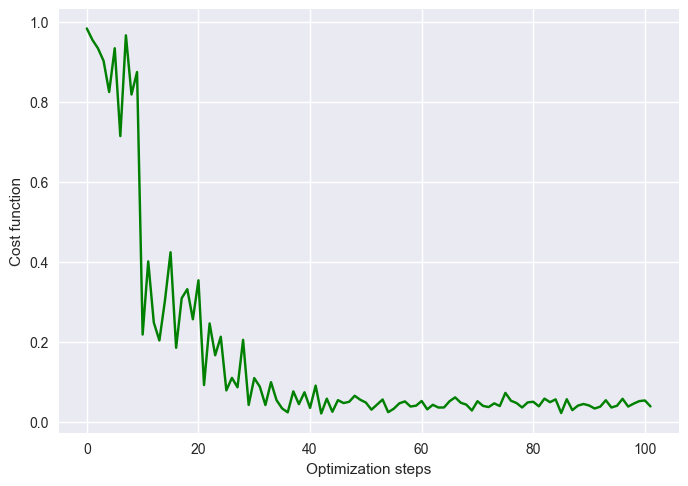

In [8]:
vqlssvmQuantum: VQLSSVM = VQLSSVM(gamma, shots)
vqlssvmQuantum.train(xTrain, yTrain, quantumSimulation=True, verbose=True, iterations = 200)

vqlssvmQuantum.plotCost()

In [9]:
print("Predictions:\n", vqlssvmQuantum.predict(xTest))
print("Accuracy: ", vqlssvmQuantum.accuracy(xTest, yTest))

Predictions:
 [ 0.0754+0.j -0.1412+0.j -0.0319+0.j  0.1412+0.j  0.1603+0.j -0.1276+0.j
 -0.2011+0.j -0.0355+0.j  0.0778+0.j  0.0389+0.j  0.043 +0.j -0.0477+0.j
  0.0064+0.j  0.027 +0.j  0.0616+0.j -0.0158+0.j  0.0228+0.j  0.1606+0.j
  0.2507+0.j -0.1401+0.j  0.05  +0.j  0.086 +0.j -0.1608+0.j  0.1356+0.j
  0.0925+0.j  0.121 +0.j  0.0517+0.j  0.1361+0.j  0.0782+0.j -0.0401+0.j
  0.1276+0.j  0.088 +0.j  0.1749+0.j  0.0459+0.j  0.1567+0.j  0.0902+0.j
 -0.0294+0.j  0.0893+0.j -0.107 +0.j  0.0322+0.j  0.1471+0.j  0.0063+0.j
  0.0985+0.j  0.0926+0.j  0.0935+0.j  0.1   +0.j  0.2109+0.j  0.1424+0.j
  0.0956+0.j  0.0774+0.j -0.0914+0.j -0.1058+0.j  0.0911+0.j  0.0866+0.j
  0.1994+0.j  0.0395+0.j  0.1891+0.j -0.2268+0.j  0.0335+0.j  0.1124+0.j
  0.0706+0.j -0.1154+0.j -0.1765+0.j  0.0244+0.j  0.0849+0.j  0.0608+0.j
  0.0072+0.j -0.0726+0.j  0.0857+0.j  0.0851+0.j  0.0547+0.j -0.0218+0.j
  0.037 +0.j -0.0117+0.j  0.2211+0.j  0.0677+0.j  0.0487+0.j  0.0357+0.j
  0.1092+0.j  0.1157+0.j -0.0333+0.j 

In [11]:
lssvmMatrix1: np.ndarray = lssvmMatrix(xTrain, gamma, "linearKernel")
yVector: np.array = prepareLabels(yTrain)
print ("Condition number of the matrix: ", np.linalg.cond(lssvmMatrix1))
print("LS-SVM Matrix:\n", lssvmMatrix1)
print(yVector)

solution: np.array = np.linalg.solve(lssvmMatrix1, yVector)
print("Solution:", solution)
print ("Norm of the solution: ",solution/np.linalg.norm(solution))

bias: float = solution[0]
weights: np.array = solution[1:]

vqlssvmLSSVM: VQLSSVM = VQLSSVM(gamma,10)
vqlssvmLSSVM.xTrain = xTrain
vqlssvmLSSVM.xTrainSize = xTrain.shape[0]
vqlssvmLSSVM.weights = weights
vqlssvmLSSVM.b = bias
predictions: np.array = vqlssvmLSSVM.predict(xTest)
# print("Predictions:", predictions)
# print(yTest)
print("Accuracy:", vqlssvmLSSVM.accuracy(xTest, yTest))

Condition number of the matrix:  4397.40886173452
LS-SVM Matrix:
 [[  0.       1.       1.       1.       1.       1.       1.       1.    ]
 [  1.     106.3387   7.9382   4.45     7.0972   9.6707   7.1253   8.6627]
 [  1.       7.9382 112.9724   9.9     11.3853  14.9474  10.5049  13.5895]
 [  1.       4.45     9.9    112.9916   8.8691  10.9625   7.0351   9.8842]
 [  1.       7.0972  11.3853   8.8691 111.003   12.9767   9.92    12.5543]
 [  1.       9.6707  14.9474  10.9625  12.9767 119.5408  11.9793  17.2147]
 [  1.       7.1253  10.5049   7.0351   9.92    11.9793 109.8428  11.4212]
 [  1.       8.6627  13.5895   9.8842  12.5543  17.2147  11.4212 116.0885]]
[ 0 -1  1  1  1  1 -1  1]
Solution: [ 0.3437 -0.0137  0.0056  0.0053  0.0058  0.0054 -0.0139  0.0055]
Norm of the solution:  [ 0.9978 -0.0397  0.0164  0.0153  0.0168  0.0156 -0.0404  0.016 ]
Accuracy: 0.6263345195729537
